# [Unsupervised Learning with `scikit-learn`](https://www.datacamp.com/completed/statement-of-accomplishment/course/de67b68fa927b24626f715322863c357497ed008)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/courses/unsupervised_learning_with_sklearn/notebook.ipynb)
[![Render nbviewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/datacamp/blob/main/notebooks/courses/unsupervised_learning_with_sklearn/notebook.ipynb)

**Contents**
- [K-means Clustering](#K-means-Clustering)
- [Heirarchical Clustering](#Heirarchical-Clustering)
- [Dimensionality Reduction](#Dimensionality-Reduction)


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.sparse import load_npz
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, Normalizer, StandardScaler, normalize


In [2]:
# music
artist_users = load_npz("artist_users.npz")
artist_names = pd.read_pickle("artist_names.pkl")

# https://eurovision.tv
eurovision_samples = np.load("eurovision_samples.npy")
eurovision_countries = pd.read_pickle("eurovision_countries.pkl")

# images
image_samples = np.load("image_samples.npy")

# https://jse.amstat.org/datasets/fishcatch.txt
fish_samples = np.load("fish_samples.npy")
fish_species = pd.read_pickle("fish_species.pkl")

# points
points = np.load("points.npy")
new_points = np.load("new_points.npy")

# https://archive.ics.uci.edu/dataset/236/seeds
seed_samples = np.load("seed_samples.npy")
seed_varieties = pd.read_pickle("seed_varieties.pkl")

# yahoo finance
stock_movements = np.load("stock_movements.npy")
stock_companies = pd.read_pickle("stock_companies.pkl")

# wikipedia
wikipedia_articles = load_npz("wikipedia_articles.npz")
wikipedia_titles = pd.read_pickle("wikipedia_titles.pkl")
wikipedia_words = pd.read_pickle("wikipedia_words.pkl")


## K-means Clustering

_k-means clustering_ is an unsupervised learning technique used to partition a dataset into $k$ clusters.

The algorithm works by randomly initializing $k$ cluster centroids (the centers of the clusters). It then iterates between two steps until the clusters stop changing:
1. Assign each data point to the cluster with the nearest centroid.
2. Update the centroids by calculating the mean of each cluster.

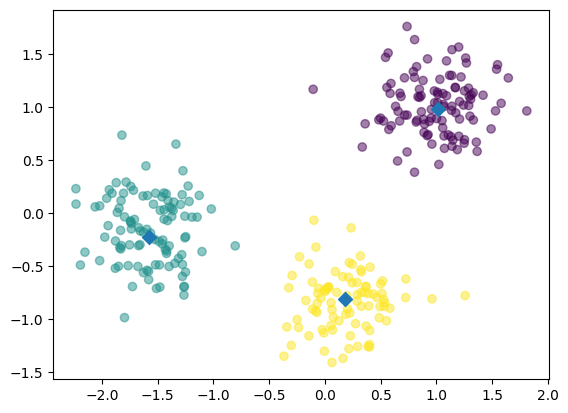

In [3]:
# fit the model
model = KMeans(n_clusters=3, n_init=10, random_state=42)
model.fit(points)

# predict the cluster labels
labels = model.predict(new_points)
xs = new_points[:, 0]
ys = new_points[:, 1]

# scatter plot using `labels` for color
plt.scatter(xs, ys, c=labels, alpha=0.5)

# assign the cluster centers
centroids = model.cluster_centers_
centroids_x = centroids[:, 0]
centroids_y = centroids[:, 1]

# scatter plot using `centroids_*` for centers
plt.scatter(centroids_x, centroids_y, marker="D", s=50)
plt.show()


### Elbow method

The _elbow method_ is a technique used to determine the optimal number of clusters for a dataset.

Start by iterating over a range of possible cluster numbers. For each number of clusters, calculate the _inertia_: the sum of squared distances of each data point to its closest cluster center.

Plot the inertia against the number of clusters. The optimal number of clusters is the point at which the inertia begins to decrease more slowly. In this case, $3$.

The "elbow" point balances cluster cohesion (fewer clusters) with cluster separation (more clusters).

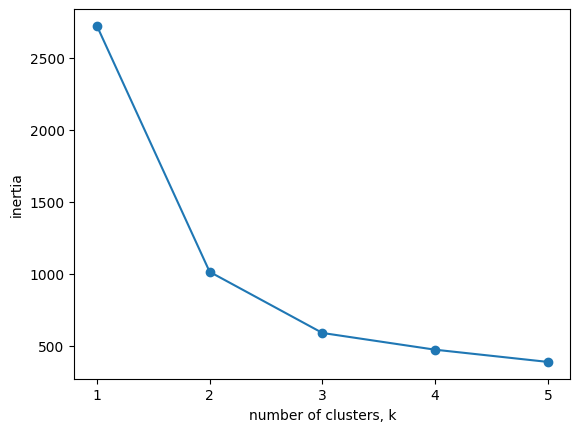

In [4]:
ks = range(1, 6)
inertias = []

for k in ks:
    # k-means model
    model = KMeans(n_clusters=k, n_init=10, random_state=42)

    # fit the model to `samples`
    model.fit(seed_samples)

    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

# plot ks vs inertias
plt.plot(ks, inertias, "-o")
plt.xlabel("number of clusters, k")
plt.ylabel("inertia")
plt.xticks(ks)
plt.show()


### Cross tabulation

A _cross tabulation_ is a table that shows the frequency of observations in each category. It is used to compare the clustering labels to the true labels (like a confusion matrix).

In [5]:
model = KMeans(n_clusters=3, n_init=10, random_state=42)

# obtain cluster labels
labels = model.fit_predict(seed_samples)

# cross tabulation
df = pd.DataFrame({"labels": labels, "varieties": seed_varieties})
ct = pd.crosstab(df["labels"], df["varieties"])
print(ct)


varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       0           1          60
1                      68           9           0
2                       2          60          10


### Scaling

$k$-means clustering is based on distance metrics (a line between two points). If the features are on different scales, the clustering will be biased towards the features with the largest values.

_Scaling_ the features to have a mean of $0$ and a standard deviation of $1$ will ensure that all features are weighted equally. In the Fish dataset, the weight in grams is a much different scale than the length in centimeters, for example.

In [6]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
pipeline = make_pipeline(scaler, kmeans)

# fit pipeline to fish samples
pipeline.fit(fish_samples)

# calculate cluster labels
labels = pipeline.predict(fish_samples)

# cross tab
df = pd.DataFrame({"labels": labels, "species": fish_species})
ct = pd.crosstab(df["labels"], df["species"])
print(ct)


species  Bream  Pike  Roach  Smelt
labels                            
0           33     0      1      0
1            0     0      0     13
2            0    17      0      0
3            1     0     19      1


### Normalization

When working with time series data, which does not follow a Gaussian distribution, _normalization_ is a better choice than scaling.

While scaling converts the data to have a mean of $0$ and a standard deviation of $1$, normalization converts the data to have a minimum of $0$ and a maximum of $1$.

In [7]:
normalizer = Normalizer()
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
pipeline = make_pipeline(normalizer, kmeans)
pipeline.fit(stock_movements)
labels = pipeline.predict(stock_movements)
df = pd.DataFrame({"labels": labels, "companies": stock_companies})
display(df.sample(n=5, random_state=42))


,labels,companies
0,7,Apple
5,9,Bank of America
36,6,Northrop Grumman
45,8,Sony
13,4,DuPont de Nemours


## Heirarchical Clustering

In _heirarchical clustering_, clusters are built by merging smaller clusters together. This can be visualized as a tree, or _dendrogram_.

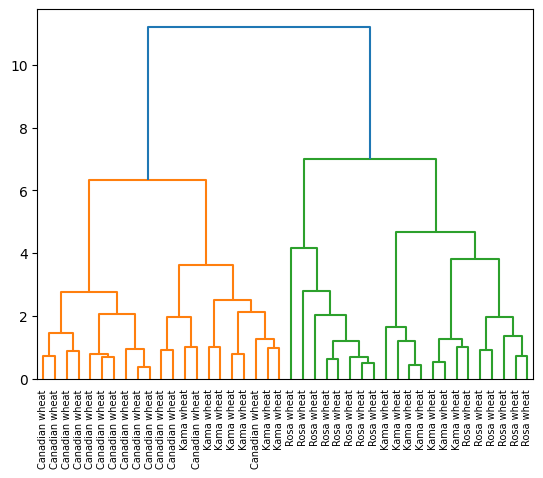

In [8]:
seed_samples_slice = seed_samples[::5]
seed_varieties_slice = seed_varieties[::5]

# calculate linkage
mergings = linkage(seed_samples_slice, method="complete")

# plot dendrogram
dendrogram(
    mergings,
    labels=seed_varieties_slice,
    leaf_rotation=90,
    leaf_font_size=7,
)
plt.show()


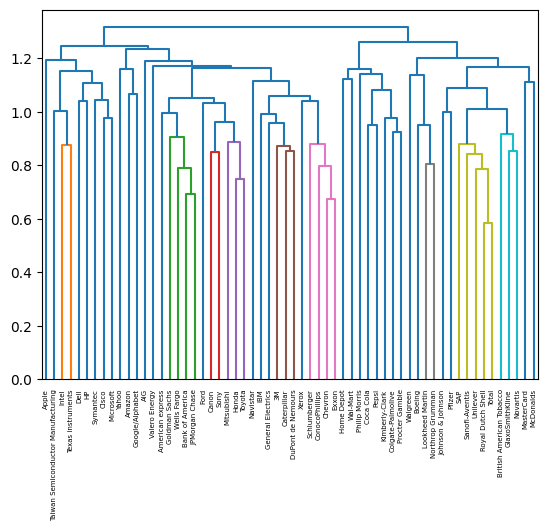

In [9]:
normalized_stock_movements = normalize(stock_movements)
mergings = linkage(normalized_stock_movements, method="complete")
dendrogram(mergings, labels=stock_companies, leaf_rotation=90, leaf_font_size=5)
plt.show()


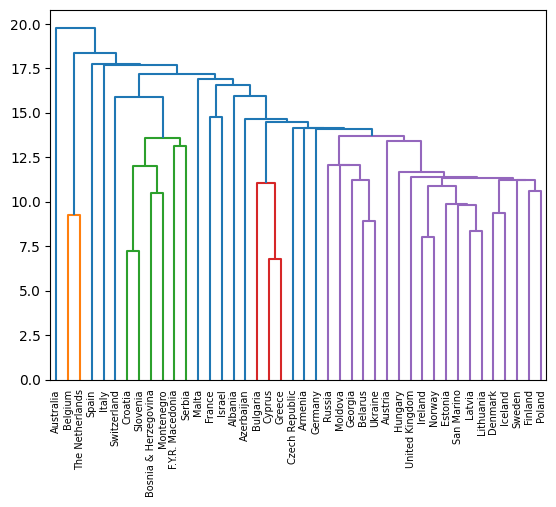

In [10]:
# use "single" linkage this time
mergings = linkage(eurovision_samples, method="single")
dendrogram(mergings, labels=eurovision_countries, leaf_rotation=90, leaf_font_size=7)
plt.show()


In [11]:
mergings = linkage(seed_samples, method="complete")

# setting a distance threshold of 6 means we will have 4 clusters
labels = fcluster(mergings, 6, criterion="distance")
df = pd.DataFrame({"labels": labels, "varieties": seed_varieties})
ct = pd.crosstab(df["labels"], df["varieties"])
print(ct)


varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                       0           0          47
2                       0          52          23
3                      13           1           0
4                      57          17           0


## Dimensionality Reduction

### t-SNE

_t-distributed Stochastic Neighbor Embedding_ (t-SNE) is a dimensionality reduction technique used to visualize high-dimensional data in low-dimensional space (2D/3D) when dealing with non-linear relationships.

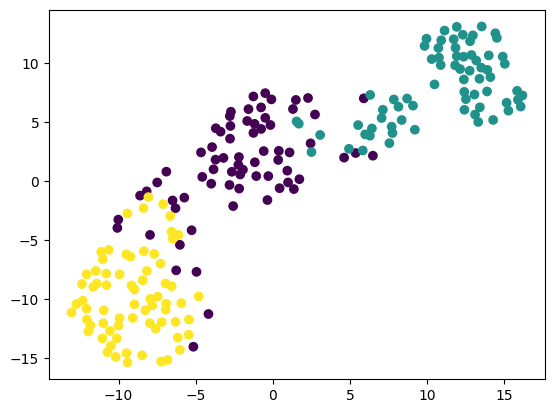

In [12]:
# encode varities as a numbered categorical feature
seed_varieties_num, _ = pd.factorize(pd.Series(seed_varieties))

# fit the model
model = TSNE(learning_rate=200, random_state=42)
tsne_features = model.fit_transform(seed_samples)

# select features
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]

# scatter plot colored by variety numbers
plt.scatter(xs, ys, c=seed_varieties_num)
plt.show()


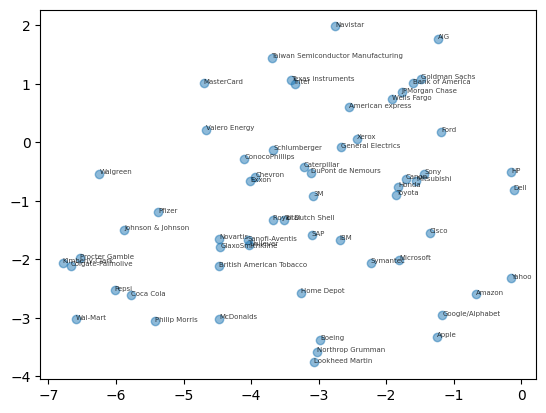

In [13]:
# normalize the stock movements
normalized_stock_movements = normalize(stock_movements)

# fit the model
model = TSNE(learning_rate=50, random_state=42)
tsne_features = model.fit_transform(normalized_stock_movements)

# select features
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]

# scatter plot
plt.scatter(xs, ys, alpha=0.5)

# annotate the points
for x, y, company in zip(xs, ys, stock_companies):
    plt.annotate(company, (x, y), fontsize=5, alpha=0.75)

plt.show()


### Principal Component Analysis

_Principal Component Analysis_ (PCA) is a dimensionality reduction technique used to reduce the number of features in a dataset while retaining the most important information. It is used when the relationships amongst variables are linear.

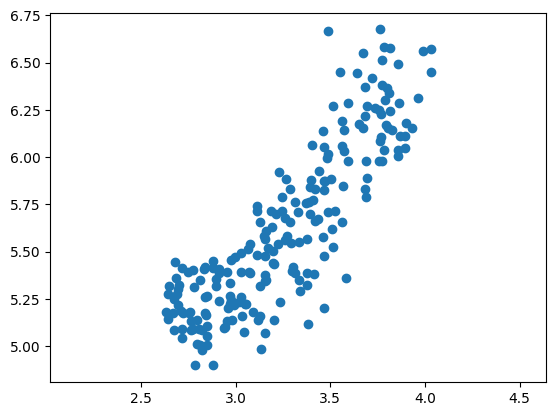

In [14]:
# width is the 5th column of seed_samples
width = seed_samples[:, 4]

# length is the 4th column of seed_samples
length = seed_samples[:, 3]

# scatter plot
plt.scatter(width, length)
plt.axis("equal")
plt.show()


In [15]:
# calculate the Pearson correlation
correlation, pvalue = pearsonr(width, length)
print(correlation)


0.8604149377143469


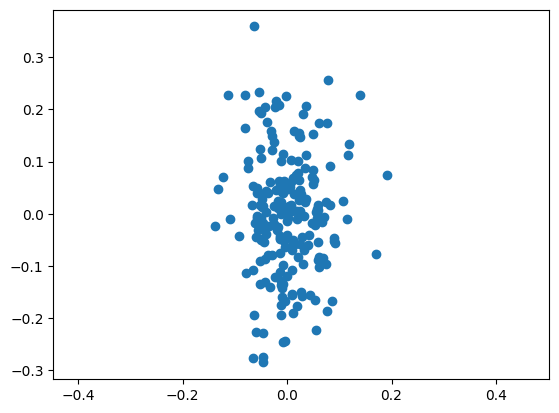

In [16]:
model = PCA(random_state=42)
pca_features = model.fit_transform(seed_samples)
xs = pca_features[:, 4]
ys = pca_features[:, 3]
plt.scatter(xs, ys)
plt.axis("equal")
plt.show()


#### Intrinsic dimension

The _intrinsic dimension_ of a dataset is the number of features needed to approximate it. It can be detected with PCA by counting the PCA features with high variance.

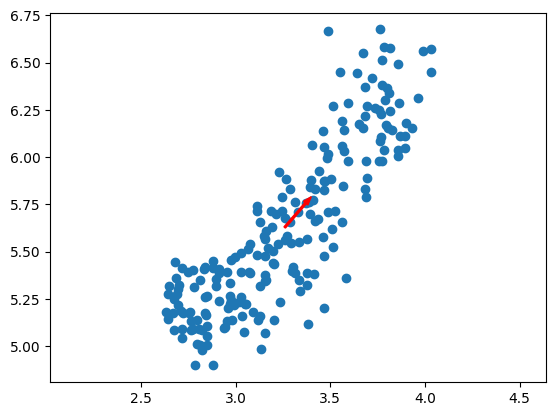

In [17]:
# scatter plot untransformed points
plt.scatter(seed_samples[:, 4], seed_samples[:, 3])

# fit PCA model to seeds
model = PCA(random_state=42)
pca_features = model.fit(seed_samples)
mean = model.mean_
first_pc = model.components_[0, :]

# plot first_pc as an arrow, starting at mean
plt.arrow(
    mean[4],
    mean[3],
    first_pc[4],
    first_pc[3],
    color="red",
    width=0.01,
)
plt.axis("equal")
plt.show()


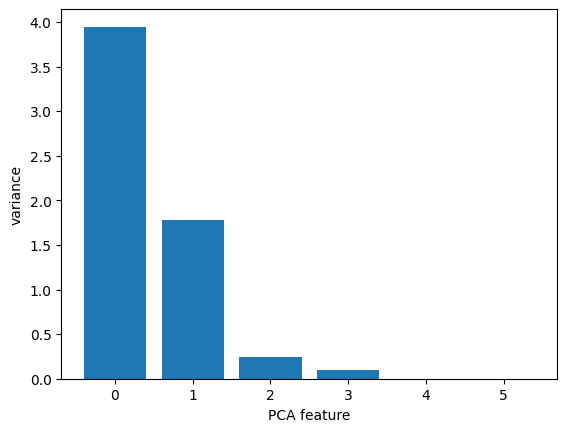

In [18]:
scaler = StandardScaler()
pca = PCA(random_state=42)
pipeline = make_pipeline(scaler, pca)
pipeline.fit(fish_samples)
features = range(pca.n_components_)

# bar plot
plt.bar(features, pca.explained_variance_)
plt.xlabel("PCA feature")
plt.ylabel("variance")
plt.xticks(features)
plt.show()


In [19]:
# scale fish samples
scaler = StandardScaler()
fish_samples_scaled = scaler.fit_transform(fish_samples)

pca = PCA(n_components=2, random_state=42)
pca.fit(fish_samples_scaled)
pca_features = pca.transform(fish_samples_scaled)
print(pca_features.shape)


(85, 2)


### Truncated Singular Value Decomposition

_Truncated Singular Value Decomposition_ (TSVD) is a dimensionality reduction technique for sparse (mostly zero values) matrices, common in text analysis (NLP).

In [20]:
svd = TruncatedSVD(n_components=50, random_state=42)
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
pipeline = make_pipeline(svd, kmeans)
pipeline.fit(wikipedia_articles)
labels = pipeline.predict(wikipedia_articles)
df = pd.DataFrame({"label": labels, "article": wikipedia_titles})
print(df.sample(n=5, random_state=42))


    label                            article
0       2                           HTTP 404
5       2                             Tumblr
36      1  2014 FIFA World Cup qualification
45      3                        Hepatitis C
13      4                   Connie Hedegaard


### Non-negative Matrix Factorization

_Non-negative Matrix Factorization_ (NMF) is a dimensionality reduction technique that can be used to extract features from high-dimensional data. It works with arrays that contain only non-negative numbers. Unlike PCA, the desired number of components must be specified.

In [21]:
model = NMF(n_components=6)
model.fit(wikipedia_articles)
nmf_features = model.transform(wikipedia_articles)
df = pd.DataFrame(nmf_features, index=wikipedia_titles)
print(df.loc["Anne Hathaway"])


0    0.003815
1    0.000000
2    0.000000
3    0.571840
4    0.000000
5    0.000000
Name: Anne Hathaway, dtype: float64


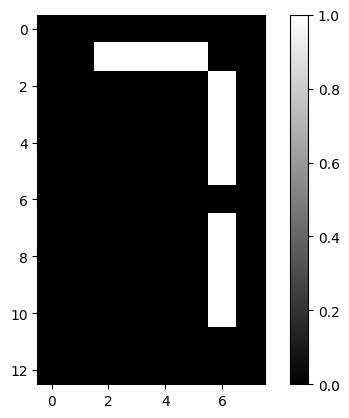

In [22]:
def show_as_image(sample):
    bitmap = sample.reshape((13, 8))
    plt.figure()
    plt.imshow(bitmap, cmap="gray", interpolation="nearest")
    plt.colorbar()
    plt.show()


show_as_image(image_samples[0, :])


In [23]:
# normalize features
model = NMF(n_components=6)
model.fit(wikipedia_articles)
nmf_features = model.transform(wikipedia_articles)
norm_features = normalize(nmf_features)

# calculate similarities
df = pd.DataFrame(norm_features, index=wikipedia_titles)
article = df.loc["Cristiano Ronaldo"]
similarities = df.dot(article)

# display relevant articles sorted by similarity
print(similarities.nlargest())


Cristiano Ronaldo                1.000000
Franck Ribéry                    0.999973
Radamel Falcao                   0.999942
Zlatan Ibrahimović               0.999942
France national football team    0.999923
dtype: float64


In [24]:
scaler = MaxAbsScaler()
nmf = NMF(n_components=20)
normalizer = Normalizer()
pipeline = make_pipeline(scaler, nmf, normalizer)
norm_features = pipeline.fit_transform(artist_users)
df = pd.DataFrame(norm_features, index=artist_names)
artist = df.loc["Bruce Springsteen"]
similarities = df.dot(artist)
print(similarities.nlargest())


Bruce Springsteen    1.000000
Leonard Cohen        0.960995
Neil Young           0.946995
The Beach Boys       0.859362
Van Morrison         0.825464
dtype: float64
